<a href="https://colab.research.google.com/github/AngelPn/Netflix-Data-Analysis/blob/main/netflix_data_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Netflix Data Mining Notebook
This notebook deals with data from a well-known content platform and production company, Netflix. The following questions will be answered:
1. Which show type is superior, the movies or the series?
2. Has Netflix invested more in movies or series in recent years?
3. Which country has the most content?
4. What kind of content (genre) does each country have?
5. Plot graphs showing the actors with the most movies in
each country. Do the same for the series.
6. Plot a graph that gathers the number of
movies depending on the suggested age. Do the same for the series.
7. If a producer wanted to have a high audience, he thinks it would
be better to make his film at a time when it does not exist much
competition. Plot a graph with the content added per month
to help him choose the right time period.
8. Prepare a chart that summarizes the types of content.
9. Plot graphs showing the directors in each country.
10. Plot graphs showing movies analog to number of seasons.
11. Which are the highest rated movies?


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Libraries

In [4]:
# For large and multi-dimensional arrays
import numpy as np
# For data manipulation and analysis
import pandas as pd
# Natural language processing library
import nltk
# For random selection 
import random
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# Machine learning libary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

import datetime
import scipy.sparse as sp

# Load Dataset
Read the data using pandas read_csv method and control missing data.

In [5]:
# enter the path
Location = r'/content/gdrive/MyDrive/ΤΕΔ/data/netflix_titles.csv'
# import os
# currentDirectory = os.getcwd()

df = pd.read_csv(Location)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


show_id  ...                                        description
0      s1  ...  In a future where the elite inhabit an island ...
1      s2  ...  After a devastating earthquake hits Mexico Cit...
2      s3  ...  When an army recruit is found dead, his fellow...
3      s4  ...  In a postapocalyptic world, rag-doll robots hi...
4      s5  ...  A brilliant group of students become card-coun...

[5 rows x 12 columns]

# Question 1
Which show type is superior, the movies or the series?

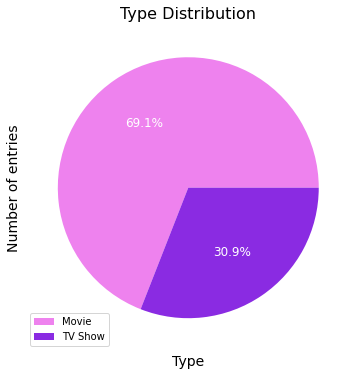

In [ ]:
res = df['type'].value_counts().to_frame()

res.plot.pie(y = 'type', colors = ['violet', 'blueviolet'], figsize = (6, 6), 
             autopct='%1.1f%%', textprops = dict(color = "w", fontsize = 12))
plt.title('Type Distribution', fontsize = 16)
plt.xlabel('Type', fontsize = 14)
plt.ylabel('Number of entries', fontsize = 14)
plt.show()

Τhe most common type is 'Movie'.

In [ ]:
print('Number of entries for "Movie": {}'.format(max(df['type'].value_counts())))

Number of entries for "Movie": 5377


# Question 2
Has Netflix invested more in movies or series in recent years?

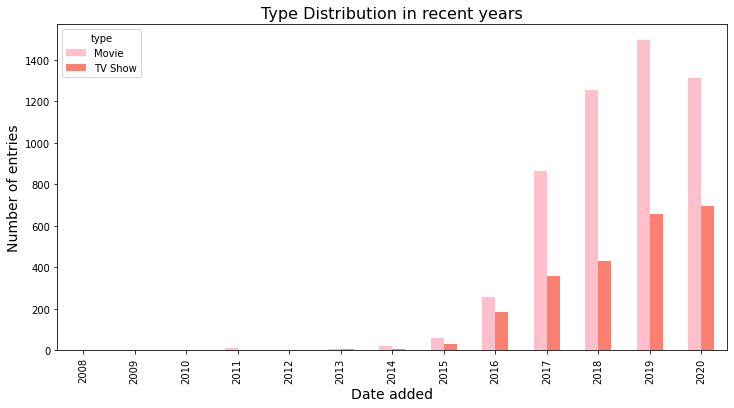

In [ ]:
# Make a list of all years from start_year to current_year (this year)
start_year = 1976
current_year = datetime.datetime.now().year
years = [str(year) for year in range(start_year, current_year)]

# Define pat: regular expression pattern with capturing groups
pat = '|'.join(years) 
# For each subject string in the Series, extract groups from the first match of regular expression pat.
s = df['date_added'].str.extract('('+ pat + ')', expand = False)

df1 = df.groupby([s,'type']).size()
df1.unstack().plot.bar(figsize = (12, 6), color = ['pink', 'salmon'])

plt.title('Type Distribution in recent years', fontsize = 16)
plt.xlabel('Date added', fontsize = 14)
plt.ylabel('Number of entries', fontsize = 14)
plt.show()

In recent years, Netflix has invested more in movies.

# Question 3
Which country has the most content (movies or series)?

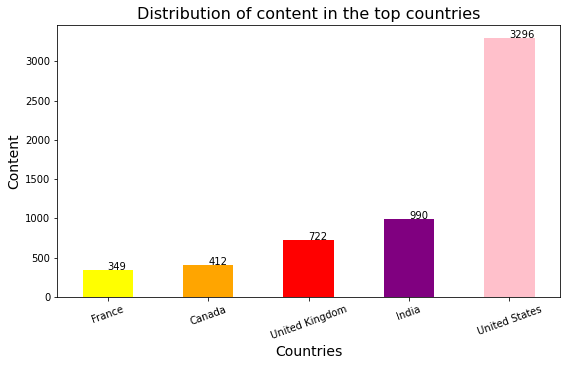

In [ ]:
# Use filter to dismiss NA values from country column
filtered_df = df[~df.country.isna()]

# Create a new dataframe from the series with show_id as the index
# splitting (exploding) columns with multiple countries into multiple rows for each country
new_df = pd.DataFrame(filtered_df.country.str.split(', ').tolist(), index = filtered_df.show_id).stack()
new_df = new_df.reset_index([0, 'show_id'])
new_df.columns = ['show_id', 'country']

content = new_df.groupby(by = 'country')['show_id'].count().sort_values().tail(5)

content.plot.bar(color = ['yellow', 'orange', 'red', 'purple', 'pink'], figsize = (9, 5), rot = 0)
for index, value in enumerate(list(content)):
    plt.text(index, value, str(value))
plt.title('Distribution of content in the top countries', fontsize = 16)
plt.xticks(rotation = 20, horizontalalignment="center")
plt.xlabel('Countries', fontsize = 14)
plt.ylabel('Content', fontsize = 14)
plt.show()

United States has the most content with 3296 movies or TV shows.

# Question 4
What kind of content (genre) does each country have?

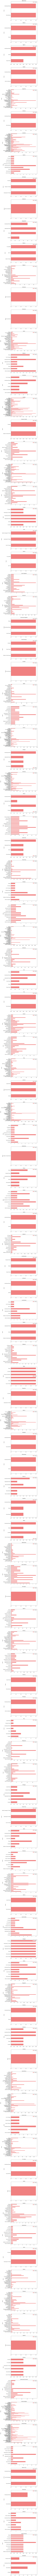

In [ ]:
# Use filter to dismiss NA values from country and listed_in columns
df_fltr = df[~df.country.isna() & (~df.listed_in.isna())]

# Explode by country and listed_in
df_new = df_fltr.assign(country = df_fltr['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index(drop = True)
df_new = df_new.assign(listed_in = df_new['listed_in'].str.strip().str.split(', ')).explode('listed_in').reset_index(drop = True)

# Group new dataframe by country and listed_in
df_group = df_new.groupby(['listed_in','country']).size().unstack()

cols = df_group.columns
fig, axes = plt.subplots(nrows = len(cols), ncols = 1, figsize = (8, 800))

# For each of the countries, plot a dataframe showing the distribution of genre in country
for idx, country in enumerate(cols):  
  res = df_group[country].reset_index([0, 'listed_in'])
  res.columns = ['Genre', 'Entries']
  res = res[~res['Entries'].isna()] # keep only the entries of genre that have values
  res.plot.barh(x = 'Genre', ax = axes[idx], color = ['lightcoral'], title = country)

plt.show()


# Question 5
Plot graphs showing the actors with the most movies in each country. Do the same for the series.

In [ ]:
# Use filter to dismiss NA values from country and cast columns
df_fltr = df[~df.country.isna() & ~df.cast.isna()]

# Explode by country and cast
new_df = df_fltr.assign(country = df_fltr['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index(drop = True)
new_df = new_df.assign(cast = new_df['cast'].str.strip().str.split(', ')).explode('cast').reset_index(drop = True)
new_df.info()
new_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67592 entries, 0 to 67591
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       67592 non-null  object
 1   type          67592 non-null  object
 2   title         67592 non-null  object
 3   director      49523 non-null  object
 4   cast          67592 non-null  object
 5   country       67592 non-null  object
 6   date_added    67524 non-null  object
 7   release_year  67592 non-null  int64 
 8   rating        67553 non-null  object
 9   duration      67592 non-null  object
 10  listed_in     67592 non-null  object
 11  description   67592 non-null  object
dtypes: int64(1), object(11)
memory usage: 6.2+ MB


show_id  ...                                        description
0      s1  ...  In a future where the elite inhabit an island ...
1      s1  ...  In a future where the elite inhabit an island ...
2      s1  ...  In a future where the elite inhabit an island ...
3      s1  ...  In a future where the elite inhabit an island ...
4      s1  ...  In a future where the elite inhabit an island ...

[5 rows x 12 columns]

## For movies
Τhe actors with the most movies in each country.

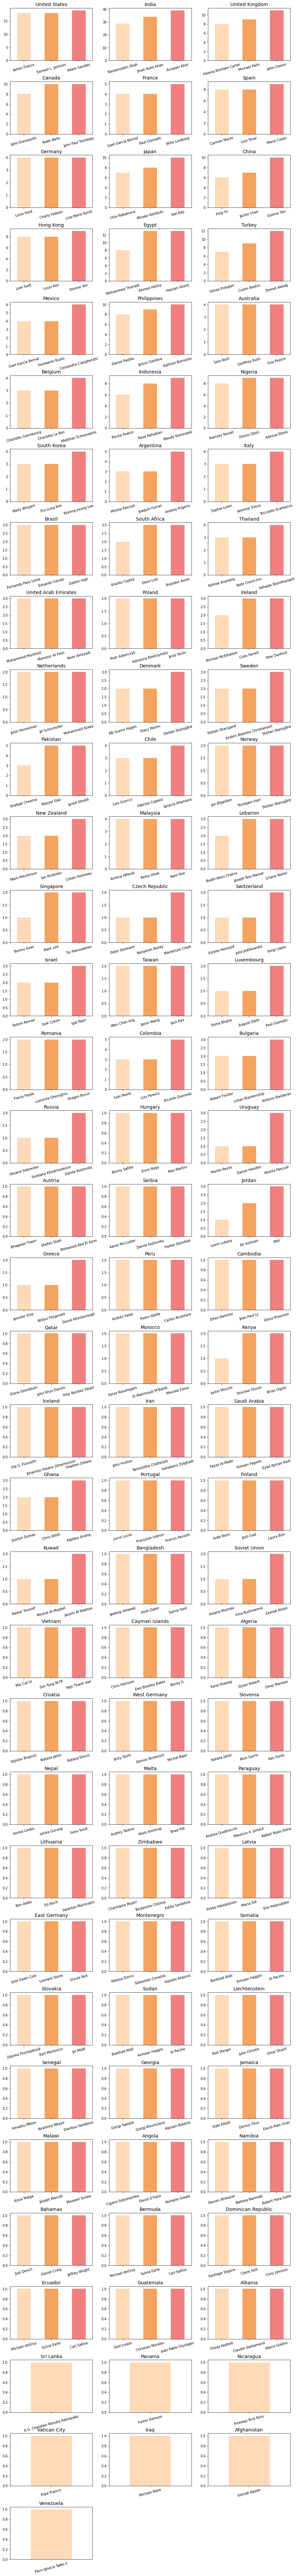

In [ ]:
countries_with_movies = new_df[new_df['type'] == 'Movie']['country'].value_counts().keys().tolist()

fig = plt.figure(figsize = (15, 140))

for idx, country in enumerate(countries_with_movies):
  ax = fig.add_subplot(35, 3, idx+1)
  result = new_df.loc[(new_df['country'] == country) & (new_df['type'] == 'Movie')]['cast'].value_counts().sort_values().tail(3)
  result.plot.bar(color = ['peachpuff', 'sandybrown', 'lightcoral'], rot = 0)
  ax.set_title(country, fontsize = 14)
  ax.tick_params('x', labelrotation = 15)

plt.subplots_adjust(hspace = 0.4)
plt.show()

## For series
The actors with the most series in each country.

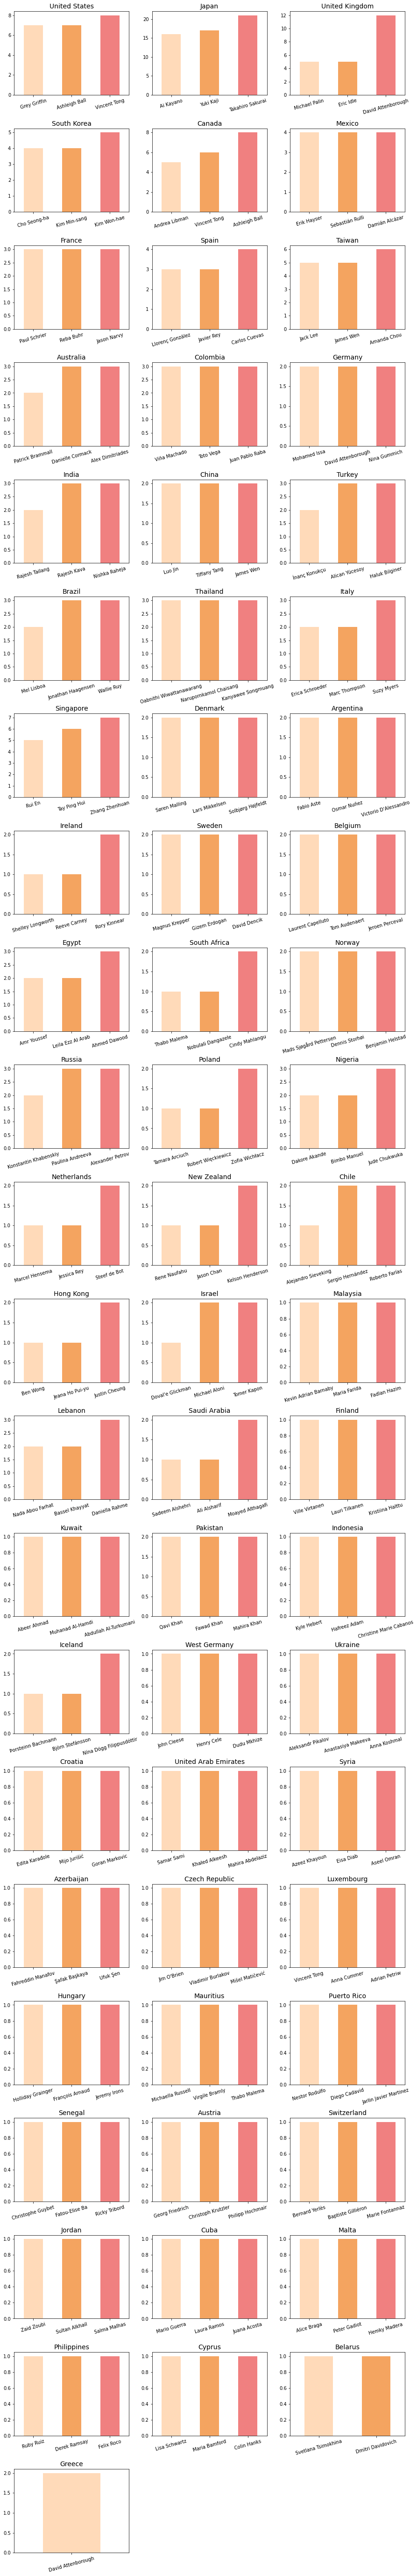

In [ ]:
countries_with_series = new_df[new_df['type'] == 'TV Show']['country'].value_counts().keys().tolist()

fig = plt.figure(figsize = (15, 100))

for idx, country in enumerate(countries_with_series):
  ax = fig.add_subplot(22, 3, idx+1)
  result = new_df.loc[(new_df['country'] == country) & (new_df['type'] == 'TV Show')]['cast'].value_counts().sort_values().tail(3)
  result.plot.bar(color = ['peachpuff', 'sandybrown', 'lightcoral'], rot = 0)
  ax.set_title(country, fontsize = 14)
  ax.tick_params('x', labelrotation = 15)

plt.subplots_adjust(hspace = 0.4)
plt.show()

# Question 6
Plot a graph that gathers the number of movies depending on the suggested age. Do the same for the series.

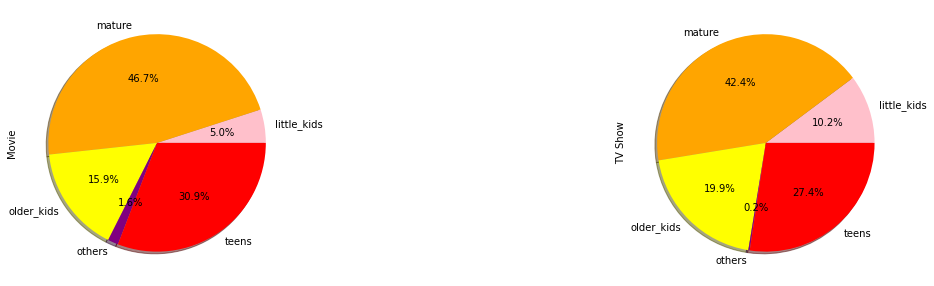

In [ ]:
little_kids = ['G', 'TV-Y', 'TV-G']
older_kids = ['PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG']
teens = ['PG-13', 'TV-14']
mature = ['R', 'NC-17', 'TV-MA']
rating_list = [little_kids, older_kids, teens, mature]
rating_names = ['little_kids', 'older_kids', 'teens', 'mature']

# Use filter to dismiss NA values from rating column
df_fltr = df[~df['rating'].isna()]
# g = np.select([df_fltr['rating'].isin(categ) for categ in rating_list],
#               rating_names,
#               'others')

# groupped_rating = df_fltr.groupby([g,'type']).size().unstack(fill_value=0)

# # groupped_rating = d.groupby(['type',g])
# # groupped_rating = groupped_rating[['show_id']].count()
# groupped_rating.plot.pie(subplots=True, figsize = (20, 5), legend=False, shadow=True, autopct='%1.1f%%', colors=['pink','orange','yellow','purple','red' ])
# plt.show()

# Question 7
If a producer wanted to have a high audience, he thinks it would be better to make his film at a time when it does not exist much competition. Plot a graph with the content added per month to help him choose the right time period.

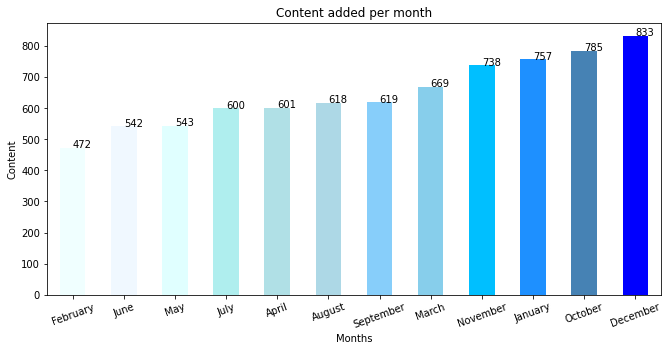

In [ ]:
# Use filter to dismiss NA values from date_added field
filtered_df = df[~df.date_added.isna()]

# Create a new dataframe from the series with show_id as the index
# extracting months
new_df = pd.DataFrame(filtered_df.date_added.str.strip().str.partition(" ")[0].tolist(), index = filtered_df.show_id).stack()
new_df = new_df.reset_index([0, 'show_id'])
new_df.columns = ['show_id', 'month']

group_df = new_df.groupby('month')['show_id'].count().sort_values()
colors = ['azure', 'aliceblue', 'lightcyan', 'paleturquoise', 'powderblue', 'lightblue', 
          'lightskyblue', 'skyblue', 'deepskyblue', 'dodgerblue', 'steelblue', 'blue']
group_df.plot.bar(color = colors, figsize = (11, 5), rot = 0)
for index, value in enumerate(list(group_df)):
    plt.text(index, value, str(value))
plt.title('Content added per month')
plt.xticks(rotation = 20, horizontalalignment="center")
plt.xlabel('Months')
plt.ylabel('Content')
plt.show()


According to plot graph, the producer should make his film in February.

# Question 8
Prepare a chart that summarizes the types of content (listed_in column).

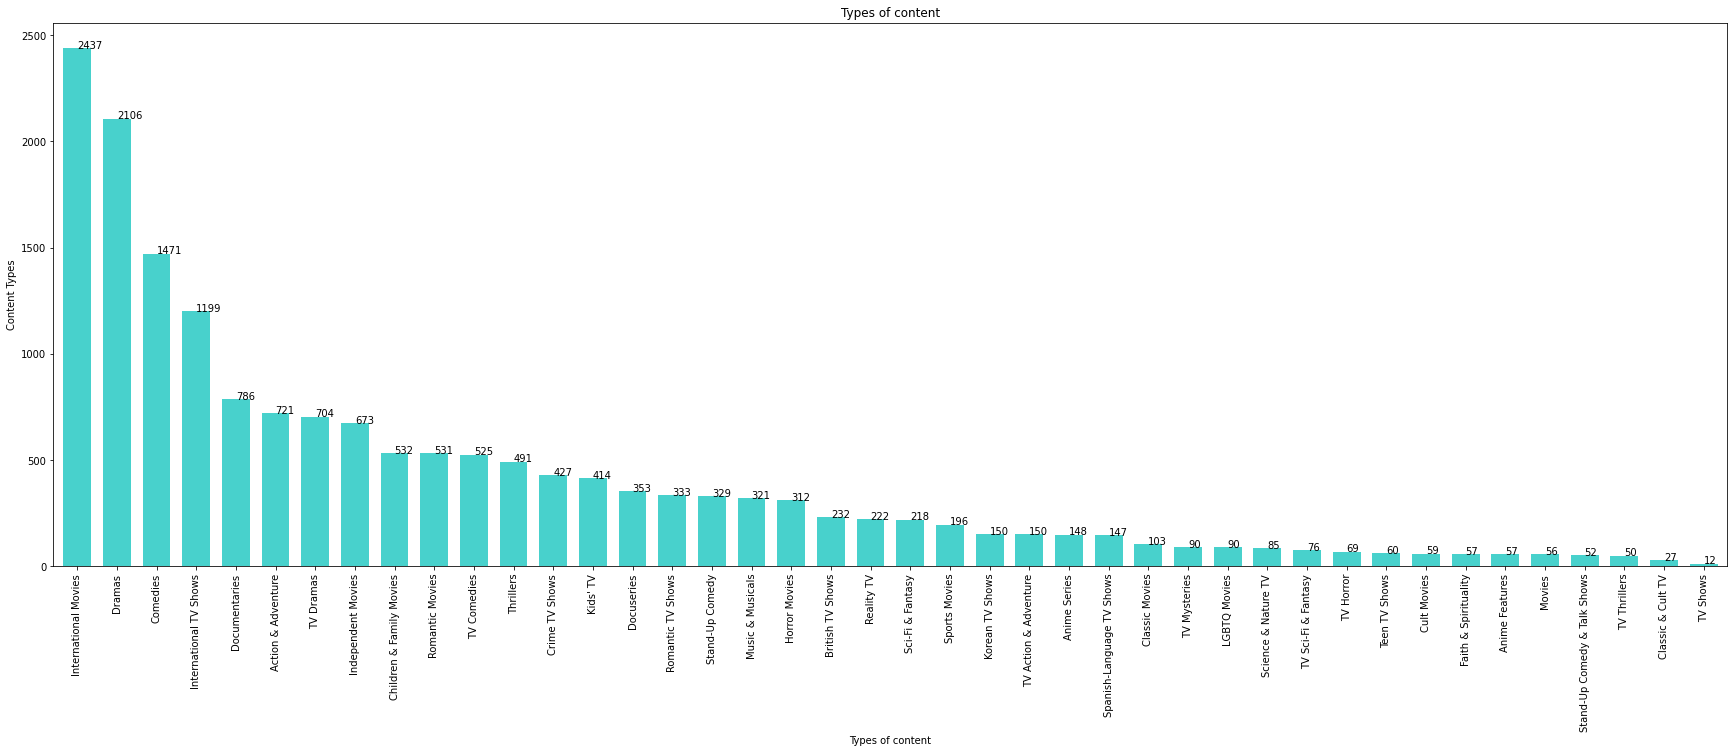

In [ ]:
# explode by kind of content
d = df[~df['listed_in'].isna()]
d['listed_in']=d['listed_in'].str.split(', ')
d = d.explode('listed_in').reset_index(drop=True)

groupped = d.groupby('listed_in').size().sort_values(ascending=False)
groupped.plot(kind='bar', figsize=(30,10), width=0.7, color='mediumturquoise')
for index, value in enumerate(list(groupped)):
    plt.text(index, value, str(value))
plt.title('Types of content')
# plt.xticks(rotation = 20, horizontalalignment="center")
plt.xlabel('Types of content')
plt.ylabel('Content Types')
plt.show()

# Question 9
Plot graphs showing the directors in each country.

In [ ]:
# Use filter to dismiss NA values from country and director fields
filtered_df = df[~df.country.isna() & ~df.director.isna()]

# Create a new dataframe from the series with new_df_index as the index
# splitting (exploding) country columns with multiple countries into multiple rows for each country
new_df_index = [filtered_df.show_id, filtered_df.director]
new_df = pd.DataFrame(filtered_df.country.str.split(', ').tolist(), index = new_df_index).stack()
new_df = new_df.reset_index([0, 'show_id', 'director'])
new_df.columns = ['show_id', 'director', 'country']

# Create a new dataframe from the series with show_id as the index
# splitting (exploding) columns with multiple directors into multiple rows for each director
new_df_index = [new_df.show_id, new_df.country]
new_df = pd.DataFrame(new_df.director.str.split(', ').tolist(), index = new_df_index).stack()
new_df = new_df.reset_index([0, 'show_id', 'country'])
new_df.columns = ['show_id', 'country', 'director']
new_df


show_id         country           director
0         s2          Mexico  Jorge Michel Grau
1         s3       Singapore       Gilbert Chan
2         s4   United States        Shane Acker
3         s5   United States     Robert Luketic
4         s6          Turkey        Serdar Akar
...      ...             ...                ...
7585   s7783     Netherlands        Josef Fares
7586   s7784           India        Mozez Singh
7587   s7787  United Kingdom           Sam Dunn
7588   s7787          Canada           Sam Dunn
7589   s7787   United States           Sam Dunn

[7590 rows x 3 columns]

## Top directors in each country

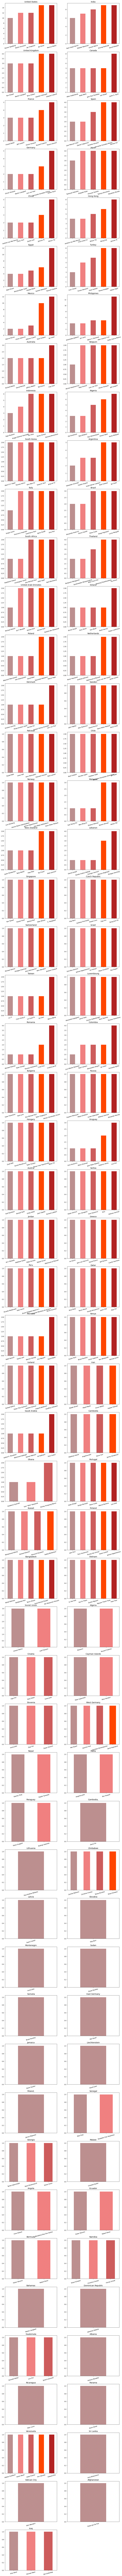

In [ ]:
countries_with_directors = new_df['country'].value_counts().keys().tolist()

fig = plt.figure(figsize = (15, 150))

for idx, country in enumerate(countries_with_movies):
  ax = fig.add_subplot(len(countries_with_directors)/2, 2, idx+1)
  result = new_df.loc[(new_df['country'] == country)]['director'].value_counts().sort_values().tail(5)
  result.plot.bar(color = ['rosybrown', 'lightcoral', 'indianred', 'orangered', 'firebrick'], rot = 0)
  ax.set_title(country, fontsize = 14)
  ax.tick_params('x', labelrotation = 15)

plt.subplots_adjust(top = 2.0)
plt.show()

## Number of directors in each country

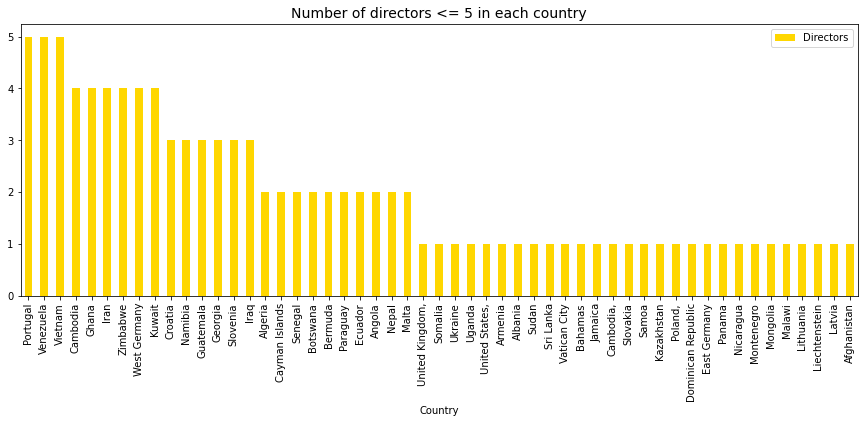

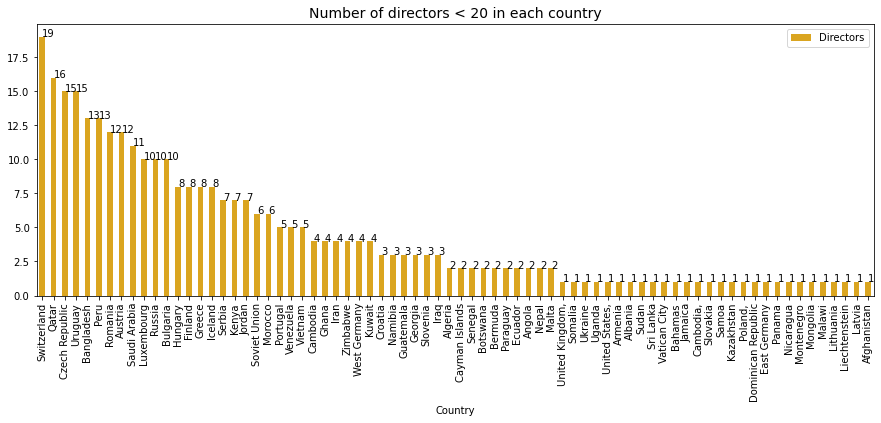

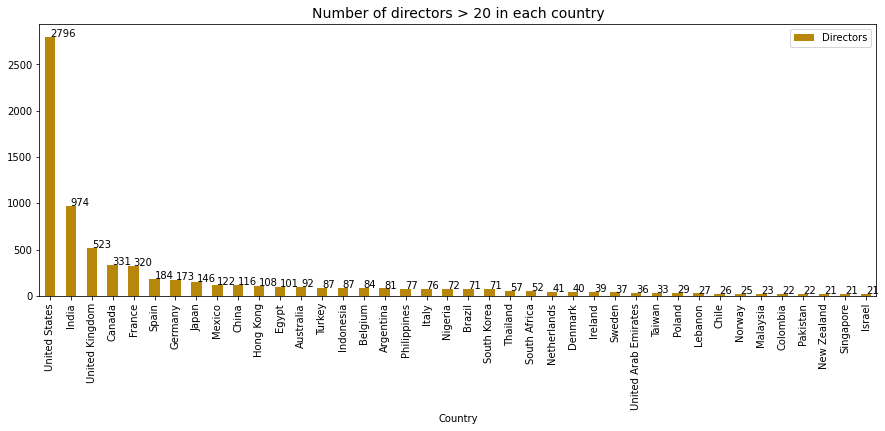

In [ ]:
# Get dataframe grouped by country and director 
# in order to keep unique directors in each country
group_df = new_df.groupby(by = ['country', 'director'])['show_id'].count().sort_values()
group_df = group_df.reset_index([0, 'country', 'director'])
group_df.pop('show_id')
# Get dataframe grouped by country
# in order to keep the number of unique directors in each country
group_df = new_df.groupby(by = ['country'])['director'].count().sort_values(ascending = False)
group_df = group_df.reset_index([0, 'country'])
group_df.columns = ['Country', 'Directors']

group1_df = group_df.loc[group_df['Directors'] <= 5]
group1_df.plot.bar(x = 'Country', y = 'Directors', figsize = (15, 5), color = 'gold')
plt.title('Number of directors <= 5 in each country', fontsize = 14)

group2_df = group_df.loc[group_df['Directors'] <= 20]
group2_df.plot.bar(x = 'Country', y = 'Directors', figsize = (15, 5), color = 'goldenrod')
plt.title('Number of directors < 20 in each country', fontsize = 14)
for index, value in enumerate(list(group2_df['Directors'])):
    plt.text(index, value, str(value))

group3_df = group_df.loc[group_df['Directors'] > 20]
group3_df.plot.bar(x = 'Country', y = 'Directors', figsize = (15, 5), color = 'darkgoldenrod')
plt.title('Number of directors > 20 in each country', fontsize = 14)
for index, value in enumerate(list(group3_df['Directors'])):
    plt.text(index, value, str(value))

plt.show()


# Question 10
Plot graphs showing TV shows analog to number of seasons.

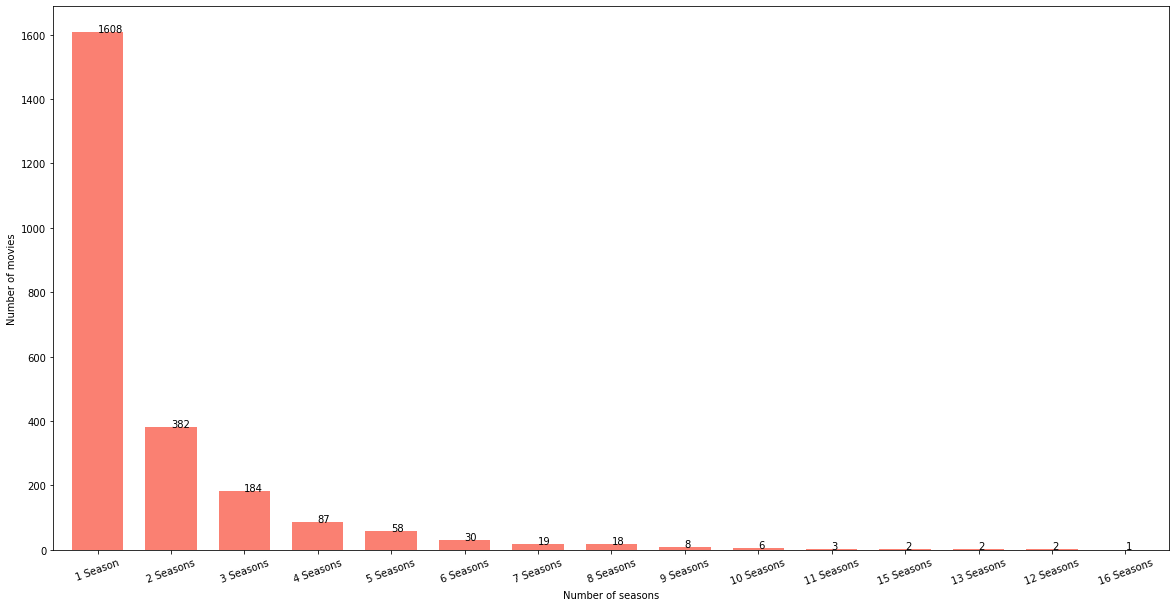

In [ ]:
d = df[df['type']=='TV Show']

d = d[~d['duration'].isna()]

groupped = d.groupby('duration').size().sort_values(ascending=False)
groupped.plot(kind='bar', width=0.7,figsize=(20,10),  color='salmon')
for index, value in enumerate(list(groupped)):
    plt.text(index, value, str(value))
plt.xticks(rotation = 20, horizontalalignment="center")
plt.xlabel('Number of seasons')
plt.ylabel('Number of movies')
plt.show()

# Question 11
Which are the highest rated movies?

Load datasets imdb movies and imbd ratings

In [ ]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/data/IMDb ratings.csv'
df_imdbratings = pd.read_csv(Location)
df_imdbratings.info()
df_imdbratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   imdb_title_id              85855 non-null  object 
 1   weighted_average_vote      85855 non-null  float64
 2   total_votes                85855 non-null  int64  
 3   mean_vote                  85855 non-null  float64
 4   median_vote                85855 non-null  float64
 5   votes_10                   85855 non-null  int64  
 6   votes_9                    85855 non-null  int64  
 7   votes_8                    85855 non-null  int64  
 8   votes_7                    85855 non-null  int64  
 9   votes_6                    85855 non-null  int64  
 10  votes_5                    85855 non-null  int64  
 11  votes_4                    85855 non-null  int64  
 12  votes_3                    85855 non-null  int64  
 13  votes_2                    85855 non-null  int

imdb_title_id  ...  non_us_voters_votes
0     tt0000009  ...                 70.0
1     tt0000574  ...                331.0
2     tt0001892  ...                123.0
3     tt0002101  ...                105.0
4     tt0002130  ...               1166.0

[5 rows x 49 columns]

In [ ]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/data/IMDb movies.csv'
df_imdbmovies = pd.read_csv(Location)
df_imdbmovies.info()
df_imdbmovies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          85855 non-null  object 
 1   title                  85855 non-null  object 
 2   original_title         85855 non-null  object 
 3   year                   85855 non-null  object 
 4   date_published         85855 non-null  object 
 5   genre                  85855 non-null  object 
 6   duration               85855 non-null  int64  
 7   country                85791 non-null  object 
 8   language               85022 non-null  object 
 9   director               85768 non-null  object 
 10  writer                 84283 non-null  object 
 11  production_company     81400 non-null  object 
 12  actors                 85786 non-null  object 
 13  description            83740 non-null  object 
 14  avg_vote               85855 non-null  float64
 15  vo

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


imdb_title_id  ... reviews_from_critics
0     tt0000009  ...                  2.0
1     tt0000574  ...                  7.0
2     tt0001892  ...                  2.0
3     tt0002101  ...                  3.0
4     tt0002130  ...                 14.0

[5 rows x 22 columns]

Find top netflix movies based on IMDb weighted average rating

In [ ]:
# We are going to match netflix movies with their name in imdb movies and take imdb_title_id to find it on imdb ratings

df_matchnames = df_imdbmovies[df_imdbmovies['title'].isin(list(df['title'])) | df_imdbmovies['original_title'].isin(list(df['title']))] #connect netflix titles with imfb's title or original title
df_matchratings = df_imdbratings[df_imdbratings['imdb_title_id'].isin(list(df_matchnames['imdb_title_id']))] # match imdb movies title id 's with imdb ratings title id 
df_matchratings.insert(1, 'title', df_matchnames['title'], True) #insert column with mathed names

#keep only the columns we need
result_df = df_matchratings[['title', 'weighted_average_vote']]
result_df
top = result_df.sort_values(by='weighted_average_vote',ascending=False).head(20)
top.reset_index(drop=True)

title  weighted_average_vote
0                                      Innocent                    9.0
1                                      Breakout                    9.0
2                                  Pulp Fiction                    8.9
3   Il Signore degli Anelli - Il ritorno del re                    8.9
4                              Schindler's List                    8.9
5                                     Inception                    8.8
6        Il Signore degli Anelli - Le due torri                    8.7
7                                        Matrix                    8.7
8                                   City of God                    8.6
9                                      Gol Maal                    8.6
10                                      Koshish                    8.6
11                       Eh Janam Tumhare Lekhe                    8.6
12                Ani... Dr. Kashinath Ghanekar                    8.6
13                        Oththa Seruppu Size 7                    8.6
14                       Much Ado About Nothing                    8.6
15                                        Joker                    8.5
16                                        Psyco                    8.5
17             The Departed - Il bene e il male                    8.5
18                        Merku Thodarchi Malai                    8.5
19                                    Mallesham                    8.5

# Recommendation system


## Preprocessing
Lemmatization

In [6]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [7]:
descriptions_list=[]
for description in list(df['description']):
  # print(description)
  doc = nlp(description)
  # lemmatized = [token.lemma_ for token in doc if not token.is_stop == True]
  for token in doc:
    if not token.is_stop == True:
      description = description.replace(token.text, token.lemma_)
  descriptions_list.append(description)
  # print(description)
df['description']=descriptions_list
df

show_id  ...                                        description
0         s1  ...  In a future where the elite inhabit an island ...
1         s2  ...  After a devastating earthquake hit Mexico City...
2         s3  ...  When an army recruit is find dead, his fellow ...
3         s4  ...  In a postapocalyptic world, rag-doll robot hid...
4         s5  ...  A brilliant group of student become card-count...
...      ...  ...                                                ...
7782   s7783  ...  When Lebanon's Civil War deprive Zozo of his f...
7783   s7784  ...  A scrappy but poor boy worm his way into a tyc...
7784   s7785  ...  In this documentary, south african rapper Nast...
7785   s7786  ...  Dessert wizard Adriano Zumbo look for the next...
7786   s7787  ...  This documentary delve into the mystique behin...

[7787 rows x 12 columns]

In [9]:
# Create a new dataframe containing only the info show_id, title, description
df_sub = df[['show_id', 'title', 'description']]

# Drop any NA value
df_sub.dropna(inplace = True)
df_sub.info()
df_sub.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7787 entries, 0 to 7786
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_id      7787 non-null   object
 1   title        7787 non-null   object
 2   description  7787 non-null   object
dtypes: object(3)
memory usage: 243.3+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


show_id  title                                        description
0      s1     3%  In a future where the elite inhabit an island ...
1      s2   7:19  After a devastating earthquake hit Mexico City...
2      s3  23:59  When an army recruit is find dead, his fellow ...
3      s4      9  In a postapocalyptic world, rag-doll robot hid...
4      s5     21  A brilliant group of student become card-count...

## Boolean Bag-of-Words

In [10]:
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=1, stop_words='english')

bow_representation = bow_vectorizer.fit_transform(df_sub.description)
print(bow_vectorizer.get_feature_names())
print(bow_representation.shape)


['000', '000 afghans', '000 chance', '000 counting', '000 euro', '000 foot', '000 grand', '000 jewish', '000 kilometer', '000 new', '000 prize', '000 round', '000 square', '000 title', '000 wasn', '000 year', '007', '007 installment', '007 james', '007 pit', '007 track', '009', '009 meet', '10', '10 000', '10 18', '10 city', '10 cornish', '10 country', '10 date', '10 day', '10 elite', '10 man', '10 million', '10 prepare', '10 seat', '10 song', '10 story', '10 week', '10 woman', '10 year', '100', '100 000', '100 brother', '100 day', '100 jews', '100 million', '100 space', '100 year', '1000', '1000 start', '102', '102 year', '10th', '10th anniversary', '10th birthday', '10th year', '11', '11 26', '11 allied', '11 day', '11 different', '11 los', '11 simple', '11 year', '112', '112 mile', '11th', '11th century', '12', '12 16', '12 1998', '12 dance', '12 finale', '12 hour', '12 magistrate', '12 murder', '12 round', '12 short', '12 year', '12 young', '12th', '12th birthday', '12th century', 

## Term Frequency - Inverse Document Frequency

In [23]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=1, stop_words='english')

tfidf_representation = tfidf_vectorizer.fit_transform(df_sub.description)
print(len(tfidf_vectorizer.get_feature_names()))
print(tfidf_representation.toarray())
print(type(tfidf_representation.toarray()))
# print(tfidf_representation)



97739
[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.1440141 0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
<class 'numpy.ndarray'>


## Similar movies

### Jaccard/Tanimoto coefficiency for BoW

In [12]:

def jaccard_similarities(matrix):
  mat = sp.csr_matrix(matrix.T, dtype='float')
  cols_sum = mat.getnnz(axis=0) # get number of columns
  ab = mat.T * mat

  # for rows
  aa = np.repeat(cols_sum, ab.getnnz(axis=0))
  # for columns
  bb = cols_sum[ab.indices]

  similarities = ab.copy()
  similarities.data /= (aa + bb - ab.data)

  return similarities.T.toarray()


print(type(bow_representation))
print(bow_representation.toarray())
jaccard_similarities = jaccard_similarities(bow_representation)

print(jaccard_similarities)


<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1.         0.         0.02040816 ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.03703704 0.         0.        ]
 [0.02040816 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.03703704 0.         ... 1.         0.         0.04      ]
 [0.         0.         0.         ... 0.         1.         0.01886792]
 [0.         0.         0.         ... 0.04       0.01886792 1.        ]]


### Cosine similarity for TF-IDF

In [13]:
# Use of cosine_similarities to return an array containing the cosine similarities of the rows of array. 
# The value in the i-th row and j-th column of the result is the cosine similarity between the i-th and j-th row of array.
cosine_similarities = cosine_similarity(tfidf_representation)

print(cosine_similarities)

[[1.         0.         0.02242956 ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.02967311 0.         0.        ]
 [0.02242956 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.02967311 0.         ... 1.         0.         0.04022579]
 [0.         0.         0.         ... 0.         1.         0.0139898 ]
 [0.         0.         0.         ... 0.04022579 0.0139898  1.        ]]


For each method, get the N indices with the maximum similarities.

In [16]:

def topN_val_indices(similarities, N = 100):
  # Fill diagonal with zeros in order to not recommend the same movie
  np.fill_diagonal(similarities, 0.0)

  #Initialize numpy array
  top_val_indices = np.zeros(shape = (len(similarities), N))
  # Get indices of N maximum values
  for i, x in enumerate(similarities):
    idx = np.argpartition(x, -N)[-N:]
    indices = idx[np.argsort((-x)[idx])]
    top_val_indices[i] = indices
  return top_val_indices


bowN_val_indices = topN_val_indices(jaccard_similarities)
tfidfN_val_indices = topN_val_indices(cosine_similarities)

print(bowN_val_indices)
print('\n')
print(tfidfN_val_indices)

[[2020. 5589. 7195. ... 1078.  177. 1667.]
 [2564. 3537. 6269. ... 1301. 6997. 1032.]
 [1190. 4869. 6440. ... 1022. 5665. 6590.]
 ...
 [5193. 3296. 2281. ... 5988. 5748. 2192.]
 [3004. 2193. 6222. ... 6127.  204. 5969.]
 [5585. 3378. 5242. ... 6226. 3851. 3830.]]


[[6023. 5821. 2045. ... 6709. 5673. 5284.]
 [2564. 6269. 7390. ... 3723. 4392. 5876.]
 [1190. 6283. 6098. ... 3287. 7761. 4736.]
 ...
 [2281. 5034. 3296. ... 5637. 5628. 1444.]
 [3004. 2193. 1279. ...   86. 3990. 4171.]
 [3378. 5585. 5242. ... 2658.  921. 3223.]]


For each movie, find the top 100 similar movies and store this information to a dictionary.

In [19]:
# Dictionaries with key a movie title and value a list with the top N similar movies
bow_similars = {}
tfidf_similars = {}

for i, row in df_sub.iterrows():

  bow_similars[row['title']] = []
  tfidf_similars[row['title']] = []

  for j in bowN_val_indices[i]:
    similar_movie = df_sub.iloc[int(j)]['title']
    bow_similars[row['title']].append(similar_movie)

  for j in tfidfN_val_indices[i]:
    similar_movie = df_sub.iloc[int(j)]['title']
    tfidf_similars[row['title']].append(similar_movie)

# print(bow_similars)
# print("/n")
# print(tfidf_similars)


## Reccomendation

### Get similarities depending on a title

In [32]:
def get_similar_movies1(title, N, method = 'boolean'):
  # find bow of the movie with given title
  if method == 'boolean':
    if title in bow_similars:
      print("Suggested movies for '" + title + "':")
      for i in range(N):
        print(bow_similars[title][i])
    else:
      print("Movie doesn't exist. Choose different movie")
  elif method == 'tf-idf':
    if title in tfidf_similars:
      print("Suggested movies for '" + title + "':")
      for i in range(N):
        print(tfidf_similars[title][i])
    else:
      print("Movie doesn't exist. Choose different movie")
  else:
    print("Invalid method.")


get_similar_movies1('14 Blades', 10)
print("\n")
get_similar_movies1('Balto 2: Wolf Quest', 10)
print("\n")
desc1 = df_sub[df_sub['title']=='Balto 2: Wolf Quest']
print(desc1.iloc[0]['description'])
print((df_sub[df_sub['title']=='Balto'].iloc[0]['description']))

print("\n")
get_similar_movies1('14 Blades', 10, 'tf-idf')
print("\n")
get_similar_movies1('Balto 2: Wolf Quest', 10, 'tf-idf')
print("\n")

# li = list(df_sub['title'])
# for x in li:
#   print(x)


Suggested movies for '14 Blades':
G-Force
Iceman
Ava
God of War
Polar
Into the Badlands
I Am Vengeance
Jarhead: Law of Return
Thong Dee Fun Khao
แผนร้ายนายเจ้าเล่ห์


Suggested movies for 'Balto 2: Wolf Quest':
Balto
Chilling Adventures of Sabrina
Alpha and Omega: The Legend of the Saw Tooth Cave
Vampires
LEGO Jurassic World: The Indominus Escape
The Princess Switch
Balu Mahi
Vroomiz
Dinotrux
Christmas in the Heartland


half-dog, half-wolf Balto (voice by Maurice LaMarche) and his wife proudly put their pup up for adoption to human, but when nobody take daughter Aleu because she look too much like a wolf, she run away to search for her place in the world.
Balto, who is half wolf and half dog, endure the taunt of disapprove human as he guide a precious cargo of medicine through the alaskan winter.


Suggested movies for '14 Blades':
G-Force
Iceman
God of War
Ava
I Am Vengeance
Into the Badlands
Jarhead: Law of Return
The Flying Guillotine
Polar
แผนร้ายนายเจ้าเล่ห์


Suggested movies fo

### Get similarities depending on a text